In [1]:
import psycopg2
import psycopg2.extras
import getpass
from IPython.display import display
import ipywidgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
dbuser = 'kennedyt' # input("DB User: ")
dbpasswd = 'loq81a5ocd6m' # getpass.getpass("DB Password: ")
db = psycopg2.connect(f"dbname='decat' user='{dbuser}' password='{dbpasswd}' host='decatdb.lbl.gov'")

db.autocommit = True # Makes the computer nicer about SQL syntax errors

cursor = db.cursor( cursor_factory = psycopg2.extras.DictCursor )

#### How many objects total in the COSMOS field?

In [3]:
query = ( 'SELECT COUNT(*) FROM objects o '
         'WHERE q3c_radial_query(o.ra,o.dec,150,2.2,3) '
         'LIMIT 10000000')
cursor.execute( query )

objnum = cursor.fetchall()[0][0]
print( objnum )

1389922


#### How many candidates total in the COSMOS field?

In [4]:
query = ( 'SELECT COUNT(*) FROM candidates c '
         'WHERE q3c_radial_query(c.ra,c.dec,150,2.2,3) ' 
         'LIMIT 10000000')
cursor.execute( query )

candnum = cursor.fetchall()[0][0]
print( candnum )

188166


#### How many objects per candidate, on average? (COSMOS)

In [5]:
obj_per_cand_av = objnum / candnum
print( obj_per_cand_av ) # This matches what we get later

del candnum, objnum, obj_per_cand_av

7.3866798465185


#### How are the objects distributed among candidates (COSMOS, ignoring RB scores)?

In [6]:
### Returns ordered pairs of [objects.candidate_id, objects.id] for each of the 9887434 objects
### Technically this section only needs candidate ids

query = ( 'SELECT candidate_id, id FROM objects o '
         'WHERE q3c_radial_query(o.ra,o.dec,150,2.2,3) '
         'LIMIT 10000000')
cursor.execute( query )

cndobj_a = np.array( cursor.fetchall() )
cndobj_a[0:7] # Just printing the first few

array([['DC21e', '1'],
       ['DC21c', '2'],
       ['DC21f', '3'],
       ['DC21d', '4'],
       ['DC21h', '5'],
       ['DC21g', '6'],
       ['DC21i', '7']], dtype='<U9')

In [7]:
cndobj_a = cndobj_a.transpose()
cndobj_a = np.sort(cndobj_a, 1)

# Finding out how many objects have a given candidate id
candidate_a, frequencies_a = np.unique( cndobj_a[0], return_counts=True )

In [8]:
pd.DataFrame( frequencies_a, candidate_a, columns=["Number of detections"]) # visualization

,Number of detections
DC21b,145
DC21ba,134
DC21baa,37
DC21baaa,31
DC21baab,24
...,...
DC21zzv,69
DC21zzw,1
DC21zzx,78
DC21zzy,20


THIS PLOT HAS LIMITED X-AXIS RANGE FOR VISIBILITY, should go out to ~700
It also includes every object, regardless of rb score


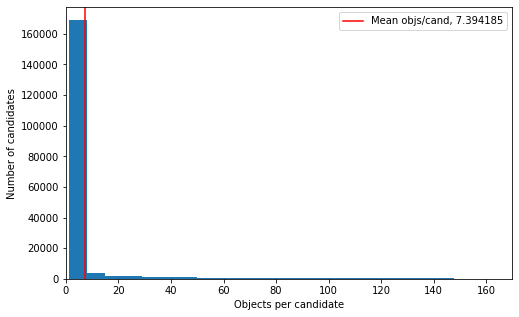

In [9]:
plt.figure( figsize=(8,5) )
plt.hist( frequencies_a, bins=100 )
plt.xlim( 0, 170 )
plt.xlabel( "Objects per candidate" )
plt.ylabel( "Number of candidates" )
plt.axvline( np.mean( frequencies_a ), label="Mean objs/cand, %f" % (np.mean(frequencies_a)), color='r' )
plt.legend()
print( "THIS PLOT HAS LIMITED X-AXIS RANGE FOR VISIBILITY, should go out to ~700" )
print( "It also includes every object, regardless of rb score" )

#### Same analysis, but for only "good" object detections (COSMOS, rb>0.6)

In [10]:
query = ( 'SELECT candidate_id, id FROM objects o '
         'WHERE rb > 0.6 '
         'AND q3c_radial_query(o.ra,o.dec,150,2.2,3) ' 
         'LIMIT 10000000')
cursor.execute( query )

cndobj_g = np.array( cursor.fetchall() )
cndobj_g[0:7] # again just taking a look at the first few

array([['DC21g', '6'],
       ['DC21k', '9'],
       ['DC21j', '11'],
       ['DC21bd', '31'],
       ['DC21bg', '33'],
       ['DC21bw', '48'],
       ['DC21by', '50']], dtype='<U9')

In [11]:
cndobj_g = cndobj_g.transpose()
cndobj_g = np.sort( cndobj_g, 1 )

# Finding out how many objects have a given candidate id
candidate_g, frequencies_g = np.unique( cndobj_g[0], return_counts=True )

In [12]:
pd.DataFrame(frequencies_g, candidate_g, columns=["Number of detections"] ) # visualization

,Number of detections
DC21b,1
DC21ba,1
DC21baaa,21
DC21baac,3
DC21baae,1
...,...
DC21zzi,28
DC21zzq,9
DC21zzr,1
DC21zzv,4


THIS PLOT HAS LIMITED X-AXIS RANGE FOR VISIBILITY, should go out to ~350
It includes only objects with rb scores above 0.6


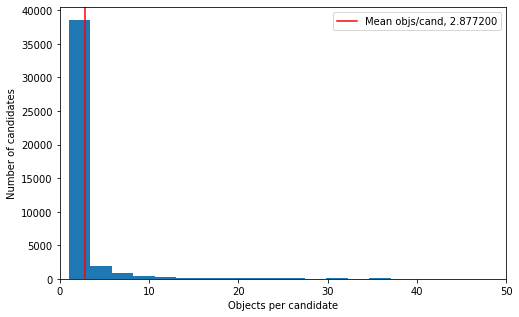

In [13]:
plt.figure( figsize=(8,5) )
plt.hist( frequencies_g, bins=150 )
plt.xlim( 0, 50 )
plt.xlabel( "Objects per candidate" )
plt.ylabel( "Number of candidates" )
plt.axvline( np.mean( frequencies_g ), label="Mean objs/cand, %f" % ( np.mean(frequencies_g) ), color='r' )
plt.legend()
print( "THIS PLOT HAS LIMITED X-AXIS RANGE FOR VISIBILITY, should go out to ~350" )
print( "It includes only objects with rb scores above 0.6" )

#### How many "Good" (R/B>0.6) sources are identified per subtraction? (COSMOS)

In [37]:
query = ( 'SELECT subtraction_id, id FROM objects o '
         'WHERE q3c_radial_query(o.ra,o.dec,150,2.2,3) '
         'AND o.rb>0.6 '
         'LIMIT 10000000')

cursor.execute( query )

subidobjid_a = np.array( cursor.fetchall() ).transpose()

In [38]:
imgs, objspersub = np.unique( subidobjid_a[0], return_counts=True )

Median is 3 objects per subtraction
Mean is 3.351487 objects per subtraction
Max is 164 objects per subtraction
Min is 1 object(s) per subtraction


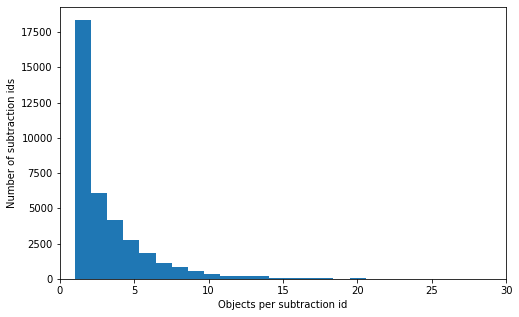

In [42]:
plt.figure( figsize=(8,5) )
plt.ylabel( "Number of subtraction ids" )
plt.xlabel( "Objects per subtraction id" )
plt.hist( objspersub, bins=150 )
plt.xlim( 0, 30 )
print( "Median is %i objects per subtraction" % ( np.median(objspersub) ) )
print( "Mean is %f objects per subtraction" % ( np.mean(objspersub) ) )
print( "Max is %i objects per subtraction" % ( np.max(objspersub) ) )
print( "Min is %i object(s) per subtraction" % ( np.min(objspersub) ) )

#### How many subtractions have been done so far? (COSMOS)

In [18]:
query = ( 'SELECT exposure_id FROM subtractions s '
         'WHERE q3c_radial_query(s.ra,s.dec,150,2.2,3) ' 
         'LIMIT 10000000' )

cursor.execute( query )

totsub = cursor.fetchall()

In [19]:
len( np.unique( totsub ) )

759

#### How many exposures have been taken? (COSMOS)

In [20]:
query = ( 'SELECT COUNT(*) FROM exposures e '
         'WHERE q3c_radial_query(e.ra,e.dec,150,2.2,3) '
         'LIMIT 10000000' )

cursor.execute( query )

totexp = cursor.fetchall()[0][0]

In [21]:
totexp

1122

#### How many "Good" (R/B>0.6) sources are identified per exposure? (COSMOS)

In [33]:
query = ( 'SELECT o.subtraction_id, o.id, s.exposure_id FROM objects o '
         'JOIN subtractions s ON o.subtraction_id=s.id '
         'WHERE q3c_radial_query(o.ra,o.dec,150,2.2,3) ' 
         'AND o.rb>0.6 '
         'LIMIT 10000000' )

cursor.execute( query )

subidobjidexpid_a = np.array( cursor.fetchall() )

In [34]:
subidobjidexpid_a

array([[      8,       6,       1],
       [      5,      11,       1],
       [     23,      31,       1],
       ...,
       [  64242, 4452253,    1538],
       [  64242, 4452266,    1538],
       [  64242, 4452275,    1538]])

In [35]:
exp, objsperimg = np.unique( subidobjidexpid_a.transpose()[2], return_counts=True )

Median is 143 objects per exposure
Mean is 163.052701 objects per exposure
Max is 756 objects per exposure
Min is 12 object(s) per exposure


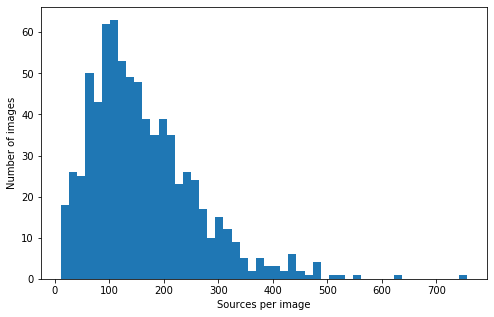

In [36]:
plt.figure( figsize=(8,5) )
plt.hist( objsperimg, bins=50 )
plt.xlabel( "Sources per image" )
plt.ylabel( "Number of images" );
print( "Median is %i objects per exposure" % ( np.median(objsperimg) ) )
print( "Mean is %f objects per exposure" % ( np.mean(objsperimg) ) )
print( "Max is %i objects per exposure" % ( np.max(objsperimg) ) )
print( "Min is %i object(s) per exposure" % ( np.min(objsperimg) ) )

#### How are R/B scores associated with the number of times a candidate is detected? (COSMOS)

Numpy's sort function was giving me a hard time, so I switched over to pandas for this one.

In [26]:
query = ( 'SELECT candidate_id, rb FROM objects o '
         'WHERE rb > 0.6 '
         'AND q3c_radial_query(o.ra,o.dec,150,2.2,3) '
         'LIMIT 10000000' )
cursor.execute( query )

cndrb_g = np.array( cursor.fetchall() ).transpose()
cndrb_g

array([['DC21g', 'DC21k', 'DC21j', ..., 'DC21bivgn', 'DC21eamv',
        'DC21bpfj'],
       ['0.999956864434353', '0.974374264478683', '0.967756569385529',
        ..., '0.980961203575134', '0.965856492519379',
        '0.620653748512268']], dtype='<U17')

In [27]:
cndrb_g_df = pd.DataFrame( cndrb_g.transpose(), columns=["Candidate ID", "RB score"] ).sort_values(by="Candidate ID")
cndrb_g_df

,Candidate ID,RB score
72176,DC21b,0.635156035423279
110091,DC21ba,0.696346163749695
47147,DC21baaa,0.719504654407501
55971,DC21baaa,0.869969934225082
54256,DC21baaa,0.884813487529755
...,...,...
106993,DC21zzv,0.787300318479538
11712,DC21zzv,0.732148230075836
97435,DC21zzv,0.988517642021179
50840,DC21zzv,0.702722370624542


In [28]:
candids, numobjs = np.unique( cndrb_g_df["Candidate ID"], return_counts=True )
rbs_raw = np.asarray( cndrb_g_df["RB score"].astype(np.float64) )

In [29]:
# This cell takes a minute or two to run
rbs_mean = [ np.mean( rbs_raw[ np.sum(numobjs[0:i]):np.sum(numobjs[0:i+1]) ] ) for i in range(len( candids ))]
rbs_median = [ np.median( rbs_raw[ np.sum(numobjs[0:i]):np.sum(numobjs[0:i+1]) ] ) for i in range(len( candids ))]

 Each data point is one candidate, and detections with rb < 0.6 are neglected


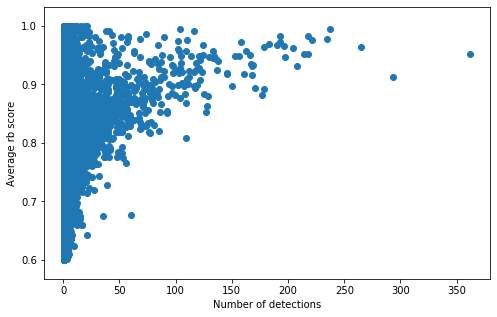

In [30]:
plt.figure( figsize=(8,5) )
plt.scatter( numobjs, rbs_mean )
plt.xlabel( "Number of detections" )
plt.ylabel( "Average rb score" )
print(" Each data point is one candidate, and detections with rb < 0.6 are neglected" )

Each data point is one candidate, and detections with rb < 0.6 are neglected


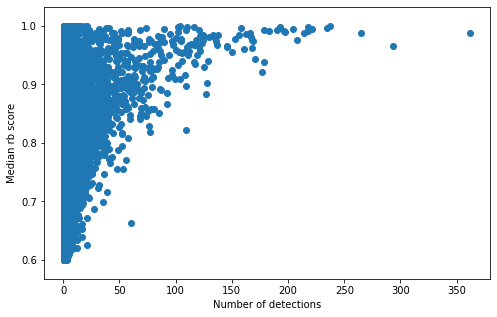

In [31]:
plt.figure( figsize=(8,5) )
plt.scatter( numobjs, rbs_median )
plt.xlabel( "Number of detections" )
plt.ylabel( "Median rb score" )
print( "Each data point is one candidate, and detections with rb < 0.6 are neglected" )

In [32]:
query = ( 'SELECT exposure_id, seeing, skysig, magzp FROM subtractions s '
         'WHERE q3c_radial_query(s.ra,s.dec,150,2.2,3) '
         'ORDER BY exposure_id ')
cursor.execute( query )

t = np.array( cursor.fetchall() )
t

array([[1.00000000e+00, 1.95086278e+00, 2.06281471e+00, 2.69702213e+01],
       [1.00000000e+00, 1.97239671e+00, 2.07567787e+00, 2.70201250e+01],
       [1.00000000e+00, 2.01037913e+00, 1.95029831e+00, 2.69296277e+01],
       ...,
       [1.53900000e+03, 1.11895466e+00, 7.84118652e+00, 2.92717657e+01],
       [1.53900000e+03, 1.21637674e+00, 7.51068115e+00, 2.91984804e+01],
       [1.53900000e+03, 1.10781579e+00, 7.61309814e+00, 2.92641965e+01]])